# Starbucks Promotion Analysis

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer **accumulates at least 10 dollars** in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example

(1) You could build a machine learning model that predicts how much someone will spend based on demographics and offer type.  
  
(2) You could build a model that predicts whether or not someone will respond to an offer.   
  
(3) You could develop a set of heuristics that determine what offer you should send to each customer. (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Analysis Overview 

1. Load in files
2. Clean the data
3. Univariate Exploration

# 1. Load in files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2. Clean the data

## (1)Portfolio

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## (2)Profile

In [3]:
# copy the dataframes
profile2 = profile.copy()

In [4]:
print(profile2.shape)
profile2.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# replace 118 in age column with nan
profile2.age = profile.age.replace(118, np.nan)

# convert "became_member_on" column to datetime type
profile2.became_member_on = pd.to_datetime(profile2.became_member_on, format="%Y%m%d")

# one_hot_encode "gender" column
profile2 = profile2.join(pd.get_dummies(profile2.gender,prefix="gender",dummy_na=True))
profile2 = profile2.drop("gender", axis = 1)

In [6]:
# replace values in "gender_F","gender_M","gender_O" clumns with nan if the gender is not unclear
for i, if_nan in enumerate(profile2.gender_nan):
    if if_nan == 1:
        profile2.loc[i, "gender_F"] = np.nan
        profile2.loc[i, "gender_M"] = np.nan
        profile2.loc[i, "gender_O"] = np.nan
profile2 = profile2.drop("gender_nan", 1)

In [7]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
age                 14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
id                  17000 non-null object
income              14825 non-null float64
gender_F            14825 non-null float64
gender_M            14825 non-null float64
gender_O            14825 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 929.8+ KB


In [8]:
# the numbere of customers whose ALL of age, income, gender are missed. 
print((profile2.isnull().sum(axis=1) == 5).sum())

2175


## (3) Transcript

In [9]:
print(transcript.shape)
transcript.sample(10)

(306534, 4)


,event,person,time,value
63219,offer received,8fcb91fc24334be398bfc8fca03223f5,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
118025,offer received,cf0046280ce841b682080a46a50de08f,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
164145,offer viewed,906cd9cfb5664a42a8d5b878b7fa4787,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
192329,transaction,bb015ae912ef496fa9b5a84b7a032b01,468,{'amount': 1.76}
168839,offer viewed,1541564cf2d14ec0ab27872f19acc4ba,414,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
231801,offer completed,e376f68b370949c8b4eb3829e28f46ae,534,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
99339,offer viewed,f27e921ee8254022a84afa2c98fd0abd,270,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
56110,offer received,fc96a24cd4bb4e65983e2598213a6c53,168,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
253542,offer received,dc4ae96efe9143ab95cde595551b7750,576,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
113941,offer received,2825186736d4433c98653bcea5957cb3,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [10]:
transcript2 = transcript.copy()

In [11]:
# remove "offer_id", "offer id", "amount" and strip each cell value (since they are clear.)

spl_list = []

for each_value in transcript2.value:
    try :
        v = str(each_value).split(": ")[1]
        #print(v)
        if v[0].isdigit():
            v = v[:-1]
            
        elif v[0] == "'":
            v = v.split("'")[1]
    except Exception as e:
        print(e, v)

    spl_list.append(v)

transcript2.value = spl_list

In [12]:
# divide the column "value" into 2 columns which are "id" (for offer_received,offer_viewed,offer_completed)
#                                                    and "reward"  (for transaction)

l_reward = []
l_offer = []

for each_value in transcript2.value:
    try:
        each_value = float(each_value)
        l_reward.append(each_value)
        l_offer.append(np.nan)
    except:
        l_reward.append(np.nan)
        l_offer.append(each_value)

transcript2["transaction"] = l_reward
transcript2["id"] = l_offer
transcript2 = transcript2.drop("value", axis=1)

print(transcript2.shape)
transcript2.head()

(306534, 5)


,event,person,time,transaction,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [13]:
transcript2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event          306534 non-null object
person         306534 non-null object
time           306534 non-null int64
transaction    138953 non-null float64
id             167581 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 11.7+ MB


# (4) 10 "id" codes in "portfolio" and "transcript2" should be more representative

In [14]:
name_mapping = {
    "ae264e3637204a6fb9bb56bc8210ddfd" : "bogo_7days$10",
    "4d5c57ea9a6940dd891ad53e9dbe8da0" : "bogo_5days$10",
    "3f207df678b143eea3cee63160fa8bed" : "info_4days",
    "9b98b8c7a33c4b65b9aebfe6a799e6d9" : "bogo_7days$5",
    "0b1e1539f2cc45b7b9fa7c272da2e1d7" : "disc_10days$20-$5",
    "2298d6c36e964ae4a3e7e9706d1fb8c2" : "disc_7days$7-$3",
    "fafdcd668e3743c1bb461111dcafc2a4" : "disc_10days$10-$2",
    "5a8bc65990b245e5a138643cd4eb9837" : "info_3days",
    "f19421c1d4aa40978ebb69ca19b0e20d" : "bogo_5days$5",
    "2906b810c7d4411798c6938adc9daaa5" : "disc_7days$10-$2"
}

In [15]:
portfolio2 = portfolio.copy().replace(name_mapping)
transcript2 = transcript2.replace(name_mapping)

# Univariate Exploration
## (1) portfolio

In [16]:
portfolio2.sort_values(["id","difficulty"])

,channels,difficulty,duration,id,offer_type,reward
1,"[web, email, mobile, social]",10,5,bogo_5days$10,bogo,10
8,"[web, email, mobile, social]",5,5,bogo_5days$5,bogo,5
0,"[email, mobile, social]",10,7,bogo_7days$10,bogo,10
3,"[web, email, mobile]",5,7,bogo_7days$5,bogo,5
6,"[web, email, mobile, social]",10,10,disc_10days$10-$2,discount,2
4,"[web, email]",20,10,disc_10days$20-$5,discount,5
9,"[web, email, mobile]",10,7,disc_7days$10-$2,discount,2
5,"[web, email, mobile, social]",7,7,disc_7days$7-$3,discount,3
7,"[email, mobile, social]",0,3,info_3days,informational,0
2,"[web, email, mobile]",0,4,info_4days,informational,0


## (2) profile

In [17]:
profile2.describe()

,age,income,gender_F,gender_M,gender_O
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300
std,17.383705,21598.299410,0.492464,0.494765,0.118729
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

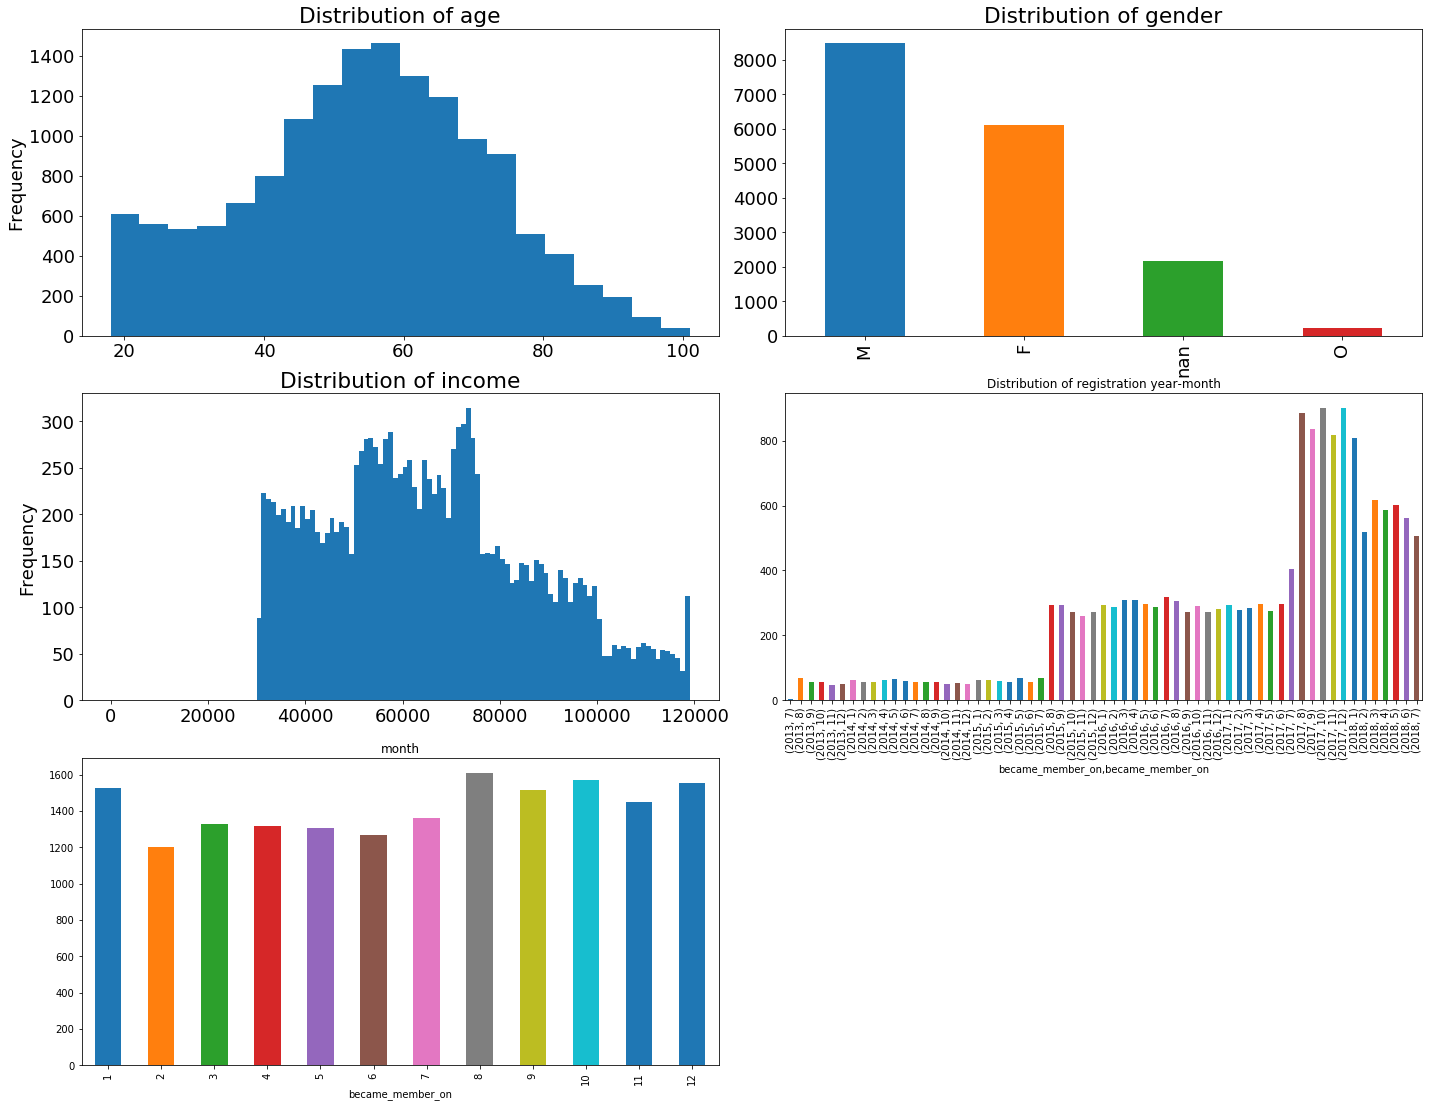

In [18]:
plt.rcParams["font.size"] = 18
plt.tight_layout()

plt.figure(figsize=[20,15])
plt.subplot(3,2,1)
plt.title("Distribution of age")
profile2.age.plot("hist", bins=20)
plt.subplot(3,2,2)
plt.title("Distribution of gender")
profile.gender.value_counts(dropna=False).plot(kind="bar")
plt.subplot(3,2,3)
plt.title("Distribution of income")
profile.income.plot("hist", bins=np.arange(0,profile2.income.max(),1000))

plt.rcParams["font.size"] = 10
plt.tight_layout()
plt.subplot(3,2,4)
plt.title("Distribution of registration year-month")
profile2.groupby([profile2.became_member_on.dt.year, profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar")

plt.subplot(3,2,5)
plt.title("month")
profile2.groupby([profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar")

In [19]:
profile2.became_member_on.dt.year.value_counts()

2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on, dtype: int64

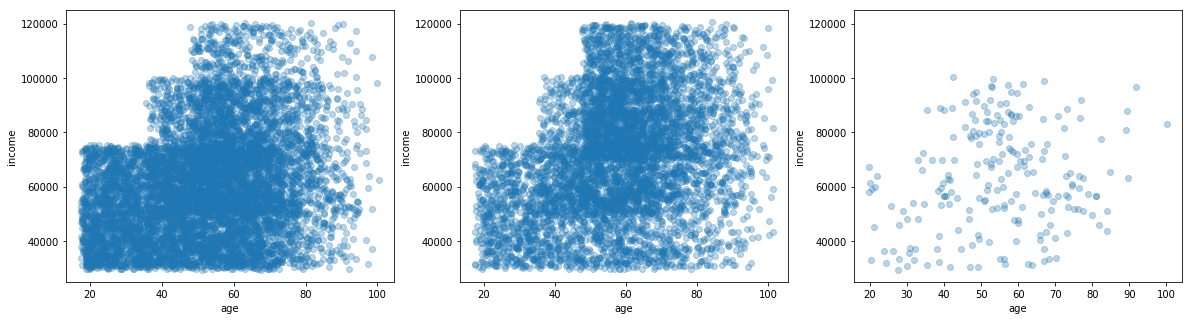

In [20]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_M == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);


plt.subplot(1,3,2)
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_F == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);


plt.subplot(1,3,3)
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_O == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);

## (3) transcript

In [21]:
# Take a look at a customer's all events in a month
transcript2[transcript2.person == "db691240326b44d8bfa7b438c4c41982"]

,event,person,time,transaction,id
1400,offer received,db691240326b44d8bfa7b438c4c41982,0,NaN,bogo_5days$10
12967,transaction,db691240326b44d8bfa7b438c4c41982,0,0.05,NaN
28037,offer viewed,db691240326b44d8bfa7b438c4c41982,42,NaN,bogo_5days$10
29685,transaction,db691240326b44d8bfa7b438c4c41982,48,1.70,NaN
32764,transaction,db691240326b44d8bfa7b438c4c41982,60,1.67,NaN
38366,transaction,db691240326b44d8bfa7b438c4c41982,84,2.44,NaN
43355,transaction,db691240326b44d8bfa7b438c4c41982,108,3.15,NaN
54583,offer received,db691240326b44d8bfa7b438c4c41982,168,NaN,disc_10days$20-$5
106022,transaction,db691240326b44d8bfa7b438c4c41982,306,0.45,NaN
112222,offer received,db691240326b44d8bfa7b438c4c41982,336,NaN,disc_10days$10-$2


In [22]:
transcript2.describe()

,time,transaction
count,306534.000000,138953.000000
mean,366.382940,12.777356
std,200.326314,30.250529
min,0.000000,0.050000
25%,186.000000,2.780000
50%,408.000000,8.890000
75%,528.000000,18.070000
max,714.000000,1062.280000


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

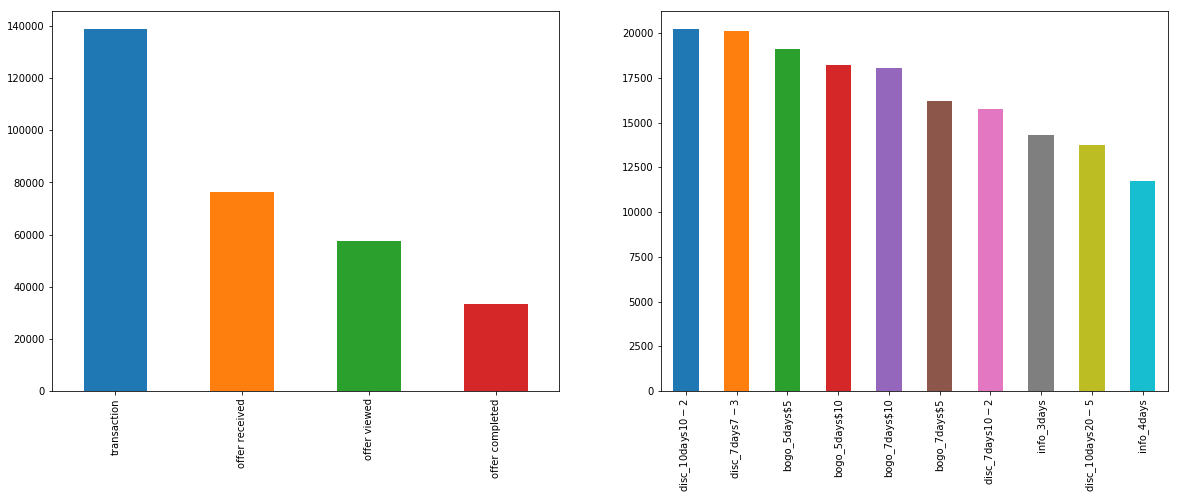

In [23]:
plt.figure(figsize=[20,7])

# Distribution of  of events
plt.subplot(1,2,1)
transcript2.event.value_counts().plot("bar")
# Distribution of offers issued
plt.subplot(1,2,2)
transcript2.merge(portfolio2, on="id").id.value_counts().plot("bar")

transcript2.event.value_counts()

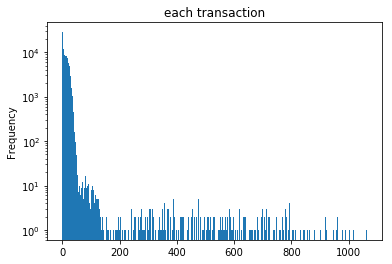

In [24]:
# Distribution of the amount of each of 138953 transactions
plt.title("each transaction")
plt.yscale("log")
transcript2.transaction.plot("hist", bins=500)

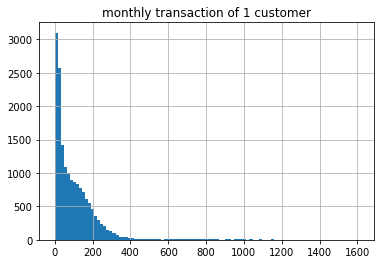

In [25]:
# Distribution of monthly total transaction amount by a customer
plt.title("monthly transaction of 1 customer")
transcript2.groupby("person")["transaction"].sum().hist(bins=100);

**I noticed that minimum transaction amount is $0.05. I have to take a look at them below.**  
I could not clarify the reason. This should be investigated better by communicating with data engineers and fellows from the marketing department.

In [26]:
transcript2[transcript2.transaction == 0.05].sample(5)

,event,person,time,transaction,id
291150,transaction,085efb39e80140f08b90e0d77299958b,648,0.05,NaN
82536,transaction,2c5dca26dcf54b7b9f39275548c84832,204,0.05,NaN
234573,transaction,56a0a16286e84bea84442d0581105459,540,0.05,NaN
103527,transaction,1c453786fd524b2e84a2ced9beac6c4a,288,0.05,NaN
44927,transaction,bdfb10a4d8ed4001a0bf9401c397df33,114,0.05,NaN


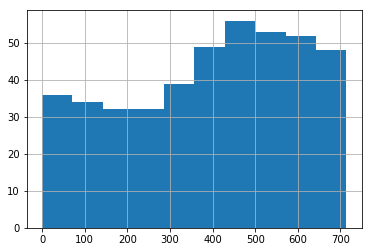

In [27]:
# When are the transactions of only $0.05 done
transcript2[transcript2.transaction == 0.05].time.hist()

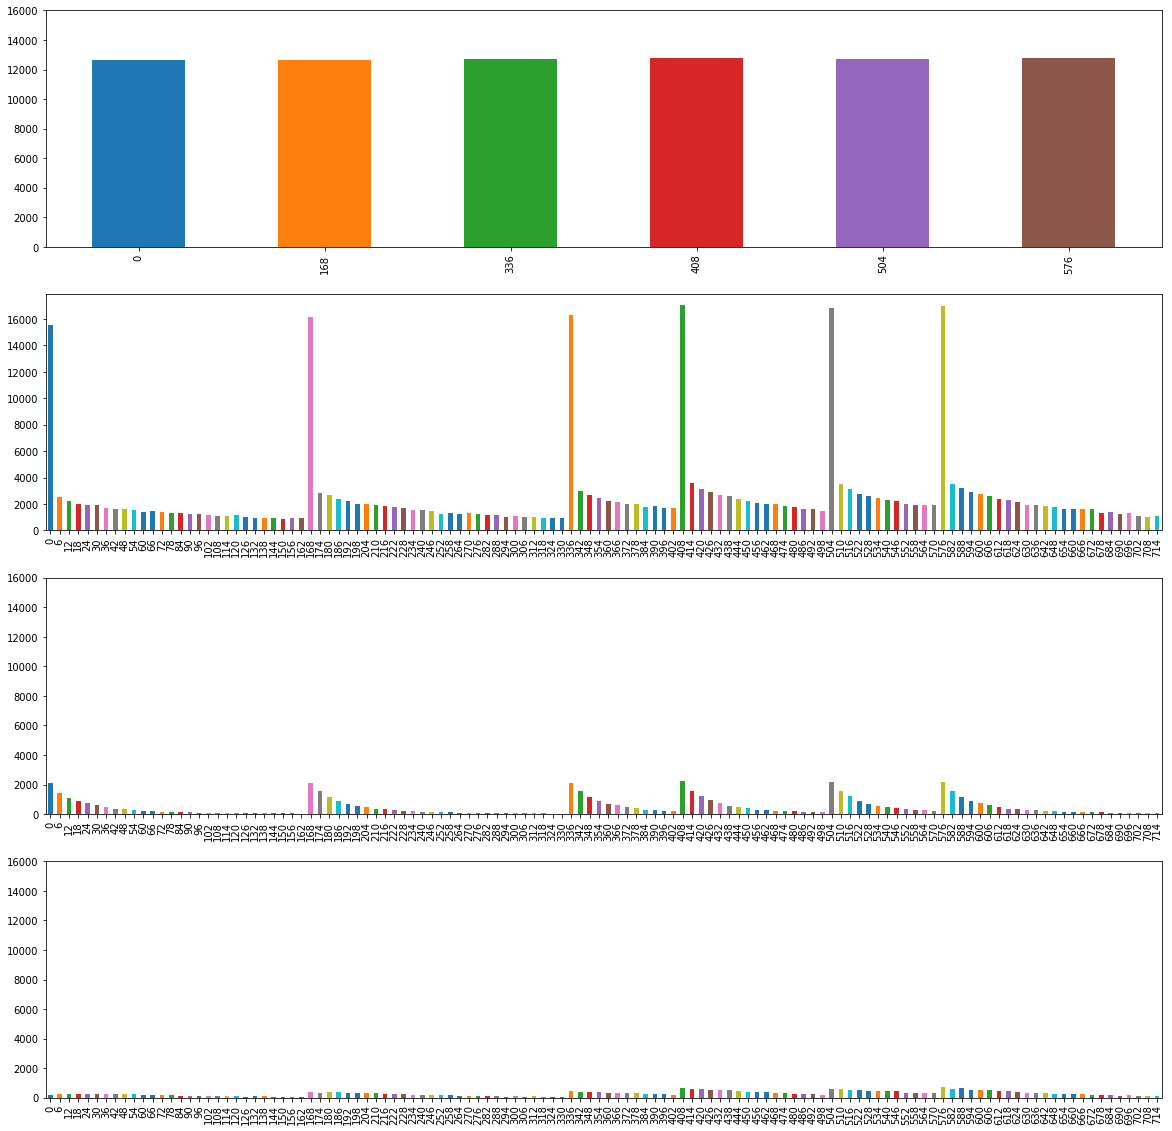

In [28]:
# Distribution of hour of transactions
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.xlim([0,714])
plt.ylim([0,16000])
transcript2[transcript2.event == "offer received"].time.value_counts().sort_index().plot("bar")


plt.ylim([0,16000])
plt.subplot(4,1,2)
transcript2.time.value_counts().sort_index().plot("bar")

# Distribution of hours when offer_received
plt.subplot(4,1,3)
plt.ylim([0,16000])
transcript2[transcript2.event == "offer viewed"].time.value_counts().sort_index().plot("bar")

# Distribution of hours when offer_completed
plt.subplot(4,1,4)
plt.ylim([0,16000])
transcript2[transcript2.event == "offer completed"].time.value_counts().sort_index().plot("bar")

In [29]:
# persons who received no offer but had transaction exist.
transcript2.groupby("person").id.count()[transcript2.groupby("person").id.count() == 0]

person
12ede229379747bd8d74ccdc20097ca3    0
3a4874d8f0ef42b9a1b72294902afea9    0
ae8111e7e8cd4b60a8d35c42c1110555    0
c6e579c6821c41d1a7a6a9cf936e91bb    0
da7a7c0dcfcb41a8acc7864a53cf60fb    0
eb540099db834cf59001f83a4561aef3    0
Name: id, dtype: int64

In [30]:
"""
plt.rcParams["font.size"] = 10
plt.tight_layout()
transcript2.groupby(by = "event").time.value_counts().unstack(0).plot.bar(figsize=(20,10))
"""

'\nplt.rcParams["font.size"] = 10\nplt.tight_layout()\ntranscript2.groupby(by = "event").time.value_counts().unstack(0).plot.bar(figsize=(20,10))\n'

In [31]:
transcript2[transcript2.event == "offer received"].time.value_counts().sort_index()

0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: time, dtype: int64

Offers are issued on **day 0, 7, 14, 17, 21, 24**.

* Offers which are valid for 10 days since day21
* Offers which are valid for 7,10 days since day24

expires after the end of observation period.
 
It should be better to remove these offer result, but if there is a bias in these offers(i.e. Offers for young women are issued on day 24 mainly), it means that the sample size for a specific demographics for a specific type of offer would be significantly small. This should be kept in mind.

......

# Direction of this project

It is suggested that the offer is completed even though it is not viewed. However I don't think this is not practical. Offer should be completed only when a user views it and displays it in the shop.

Also, I consider that hesitating to send offers to NEW customers does not make sense. The only information about new customers is only age, gender, income and the date of registration. I personally think that Starbucks should send offers to all the new customers. 

That being said, what I think really useful is to 

(1)make a model which predicts the probability that each customer would go and complete each of offer types  in the condition that one view it **BASED ON BOTH PAST BEHAVOIR AND ATTRIBUTE.

(Maybe making a model which predicts the 

In [ ]:
transcript2.sort_values(["person", "time"])

In [ ]:
transcript2[transcript2.event == "offer viewed"]